# INTRODUCTION<BR>
    
Time-series forcasting is one of most exciting fields of application in the domain of data science. It has endless supply of problems from various topics of interest, such as - in finance, forcasting stock prices and trend behavior overtime, global issues such as forcasting unemployement in each quater, also in medical- number of babies born every minutes, number of new cases under a pandemic, to name a few. 

# Importing tools

In [106]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
from numpy.random import normal, seed
import math
from sklearn.metrics import mean_squared_error

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import norm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

Dataset: This includes the stock data of Nifty-50 index from NSE (National Stock Exchange) India over the last 20 years (2000 - 2019). I am going to explore the stock market data of Bajaj Finance.

In [107]:
df = pd.read_csv('BAJFINANCE.csv', parse_dates=["Date"],index_col="Date")
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,BAJAUTOFIN,EQ,46.95,49.45,50.75,46.5,50.75,50.75,50.05,7600,3.803800e+10,NaN,NaN,NaN
2000-01-04,BAJAUTOFIN,EQ,50.75,53.20,53.20,47.9,48.00,48.10,48.56,5000,2.428000e+10,NaN,NaN,NaN
2000-01-05,BAJAUTOFIN,EQ,48.10,46.55,47.40,44.6,44.60,44.60,45.47,3500,1.591450e+10,NaN,NaN,NaN
2000-01-06,BAJAUTOFIN,EQ,44.60,43.50,46.00,42.1,46.00,45.25,44.43,6200,2.754750e+10,NaN,NaN,NaN
2000-01-07,BAJAUTOFIN,EQ,45.25,48.00,48.00,42.0,42.90,42.90,44.44,3500,1.555550e+10,NaN,NaN,NaN


In [108]:
df.Series.unique()

array(['EQ'], dtype=object)

In [109]:
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-08-25,BAJFINANCE,EQ,3492.05,3525.00,3660.00,3510.00,3658.00,3642.90,3579.12,9854070,3.526895e+15,339815.0,1498309.0,0.1520
2020-08-26,BAJFINANCE,EQ,3642.90,3665.00,3707.00,3631.00,3638.20,3645.55,3668.17,6665336,2.444958e+15,213994.0,944373.0,0.1417
2020-08-27,BAJFINANCE,EQ,3645.55,3656.95,3668.40,3596.40,3636.00,3632.50,3631.13,4611132,1.674361e+15,162374.0,387513.0,0.0840
2020-08-28,BAJFINANCE,EQ,3632.50,3650.00,3688.00,3617.05,3672.05,3670.80,3652.77,4251575,1.553003e+15,137033.0,434147.0,0.1021
2020-08-31,BAJFINANCE,EQ,3670.80,3715.00,3749.85,3465.00,3478.50,3487.80,3602.93,8529788,3.073224e+15,293454.0,1321559.0,0.1549


# Features:
1. Series: Here EQ stands for equity series of stock market.
2. Prev Close: The closing price of the stock for the day before.
3. Open,High, Low, Last, Close: The opening price, highest price, lowest price, last price and closing price of Bajaj Finance shares on the current day.
4. **VWAP**: Volume Weighted Average Price,the **target variable** to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.
5. Volume: Volume of shares traded on the current day.
6. Turnover: It is a measure of stock liquidity calculated by dividing the total number of shares traded over a period by the average number of shares outstanding for the period. 
7. Trades: total number of trades on the current day.
8. Deliverable Volume:  is the quantity of shares which actually move from one set of people to another set of people.
9. Deliverable(%): Deliverable volume in percentage.

# Exploring the data
Let's explore the missing values, trend, seasonality, correlation and noise in the data.

In [110]:
df.shape

(5070, 14)

In [111]:
# Check for missing values

df.isna().sum()

Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2779
Deliverable Volume     446
%Deliverble            446
dtype: int64

Trades, Deliverable volume and %Deliverable are the columns with missing values.

In [112]:
print("Percentage of missing trade values = {:.2f}".format(100*(df['Trades'].isna().sum())/df.shape[0]))
print("Percentage of missing Deliverable Volume values = {:.2f}".format(100*(df['Deliverable Volume'].isna().sum())/df.shape[0]))
print("Percentage of missing %Deliverble values = {:.2f}".format(100*(df['%Deliverble'].isna().sum())/df.shape[0]))

Percentage of missing trade values = 54.81
Percentage of missing Deliverable Volume values = 8.80
Percentage of missing %Deliverble values = 8.80


So more than 50% trade data is missing, while only 10% each of deliverable volume and deliverable% is missing. We can drop the rows where deliverable volume is missing. For trade data, we will visualize it to understand the best statistic for imputation.

In [113]:
df = df[df['Deliverable Volume'] >0]

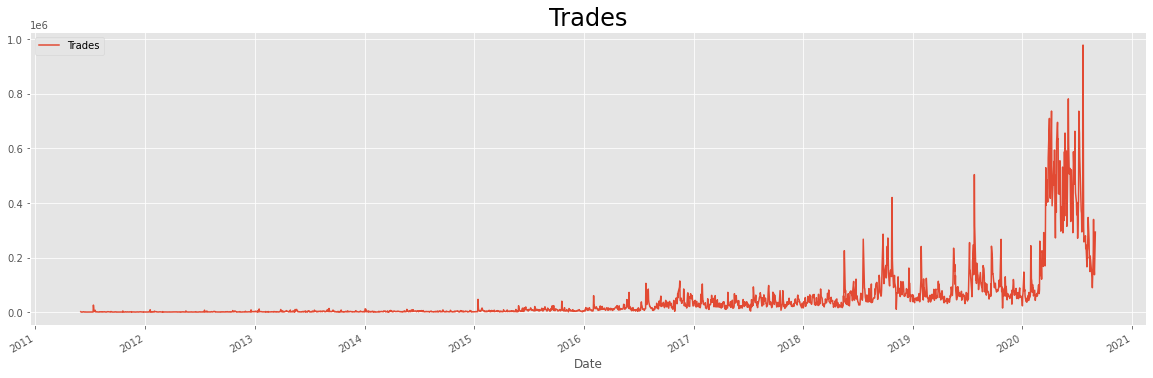

In [114]:
ax = df[['Trades']].plot(figsize=(20, 6))
ax.set_title('Trades', fontsize=24);

We can see that trade values show a pulse in growth from the period of 2020 - 2021. To fill the NaN values, perhaps the safest option is to forward fill. But since many consecutive rows have missing values, we can fill with mean value.

In [115]:
df['Trades'].ffill(axis = 0) 
trade_data = df.loc[df.index<='2019']
mean = round(trade_data['Trades'].mean(),1)
df["Trades"].fillna(value = mean,inplace = True)

# Visualizing trends in stock prices

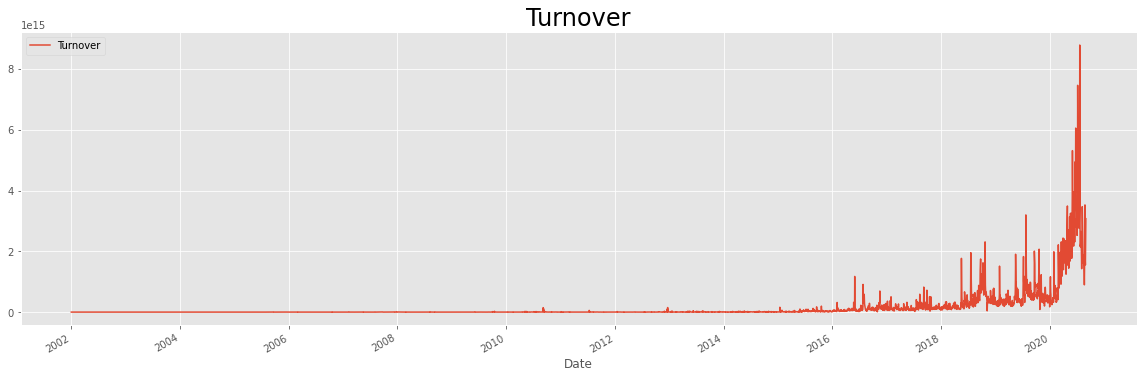

In [116]:
ax = df[['Turnover']].plot(figsize=(20, 6))
ax.set_title('Turnover', fontsize=24);

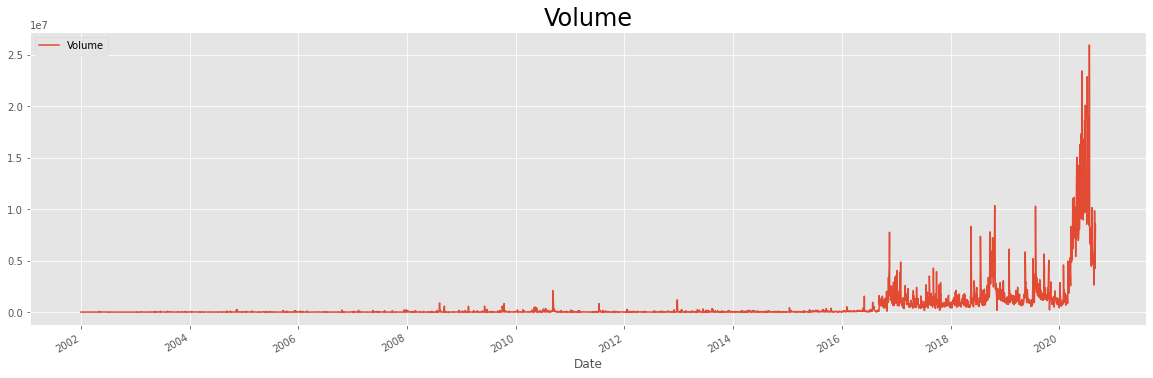

In [117]:
ax = df[['Volume']].plot(figsize=(20, 6))
ax.set_title('Volume', fontsize=24);

The volume of shares traded showed a sharp growth during the period of 20-21.

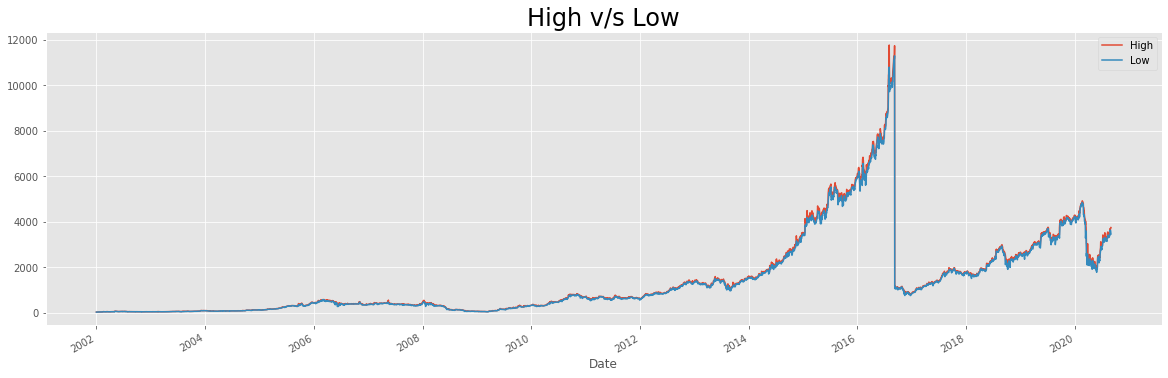

In [118]:
ax = df[['High', 'Low']].plot(figsize=(20, 6))
ax.set_title('High v/s Low', fontsize=24);

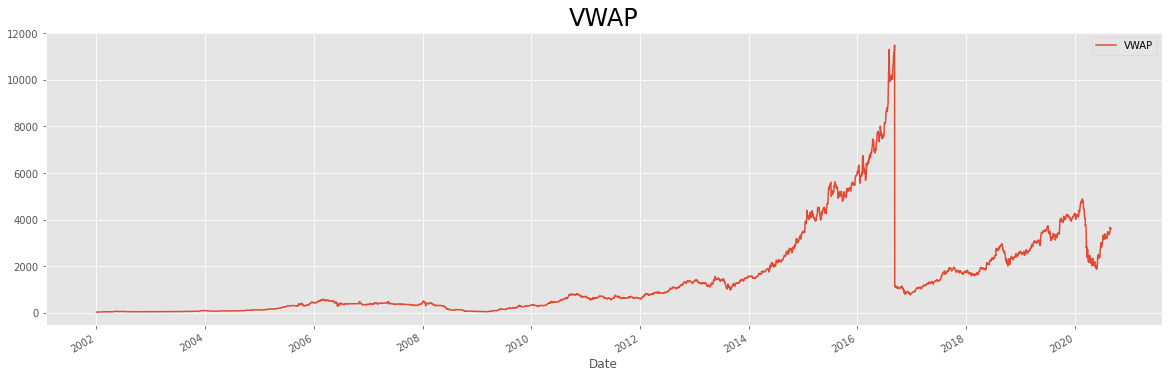

In [119]:
ax = df[['VWAP']].plot(figsize=(20, 6))
ax.set_title('VWAP', fontsize=24);

Even though turnover and volume increased during the year 20-21, the prices dropped significantly. This explains the fact that, due to the pandemic 
Covid-19, many investors took the advantage of dropping prices to buy stocks in bulk, perhaps looking forward to sell when industries regain momentum.

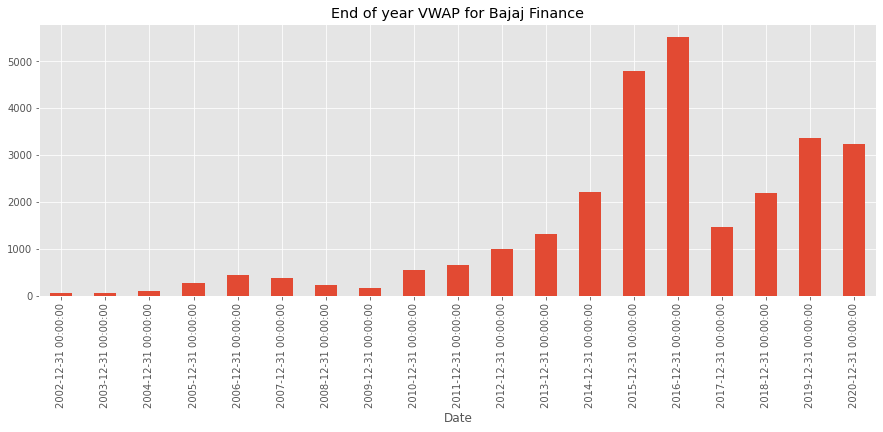

In [120]:
df['VWAP'].resample('A').mean().plot(kind='bar', figsize=(15,5))
plt.title('End of year VWAP for Bajaj Finance')
plt.show()

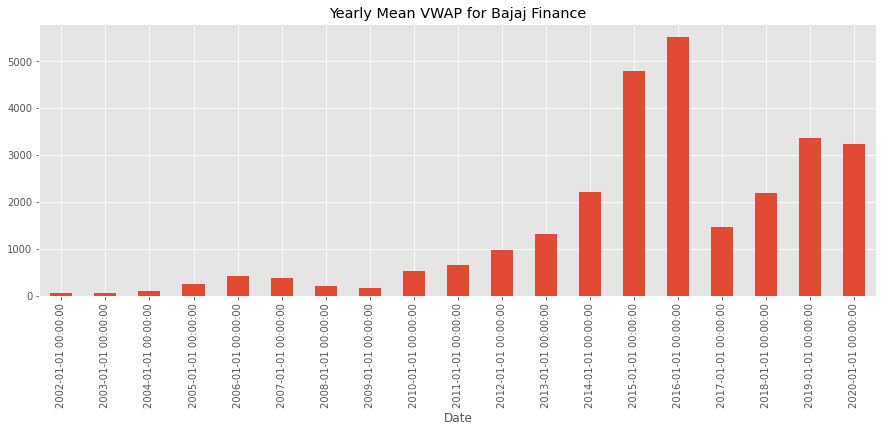

In [121]:
df['VWAP'].resample('AS').mean().plot(kind='bar', figsize=(15,5))
plt.title('Yearly Mean VWAP for Bajaj Finance')
plt.show()

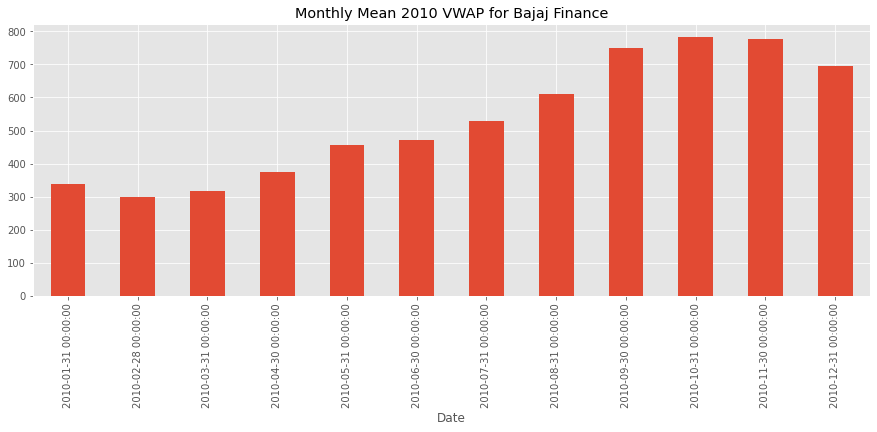

In [122]:
df['VWAP']['2010'].resample('M').mean().plot(kind='bar', figsize=(15,5))
plt.title('Monthly Mean 2010 VWAP for Bajaj Finance')
plt.show()

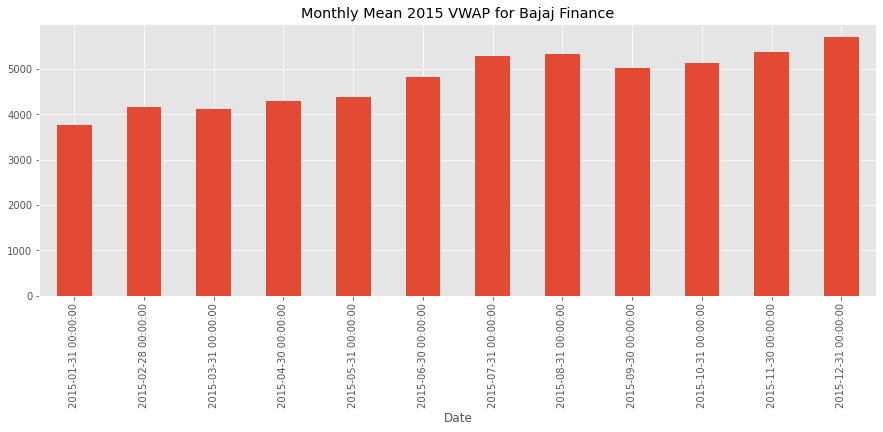

In [123]:
df['VWAP']['2015'].resample('M').mean().plot(kind='bar', figsize=(15,5))
plt.title('Monthly Mean 2015 VWAP for Bajaj Finance')
plt.show()

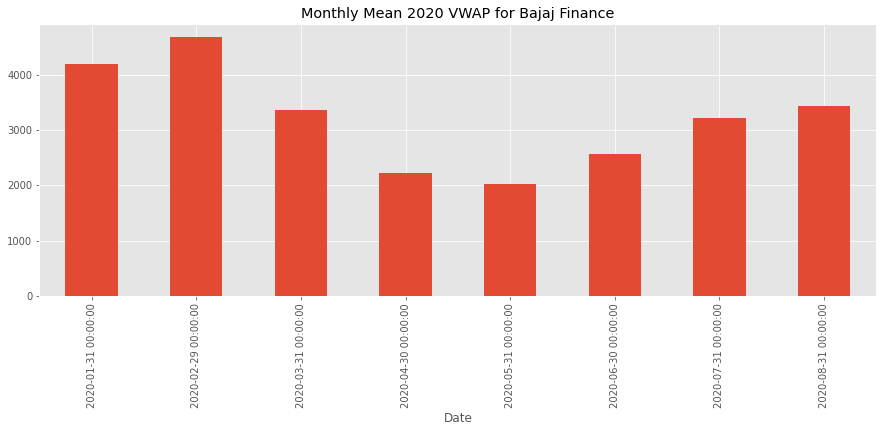

In [124]:
df['VWAP']['2020'].resample('M').mean().plot(kind='bar', figsize=(15,5))
plt.title('Monthly Mean 2020 VWAP for Bajaj Finance')
plt.show()

VWAP has decreased on average in a decade(2010-2020).

Box-Cox Transformation - to generate a uniform distribution.

In [125]:
from scipy.stats import boxcox

Lambda: 0.075464


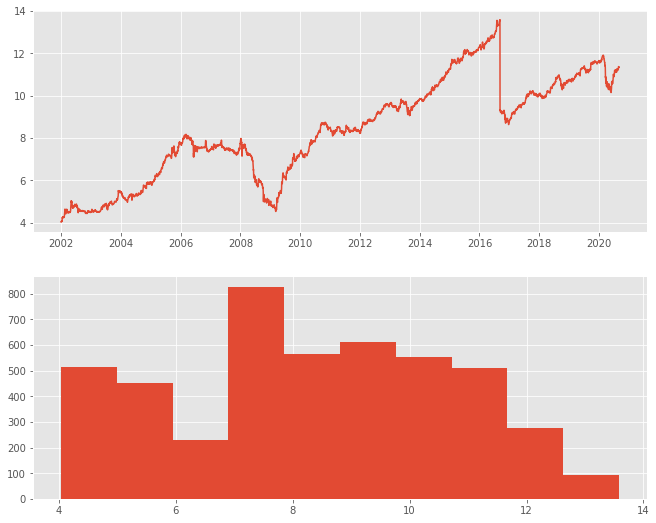

In [126]:
df['vwap_boxcox'],lam = boxcox(df['VWAP'])
print('Lambda: %f' % lam)
rcParams['figure.figsize'] = 11, 9
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(df['vwap_boxcox'])
# histogram
pyplot.subplot(212)
pyplot.hist(df['vwap_boxcox'])
pyplot.show()

# Moving average smoothing
Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

By plotting rolling

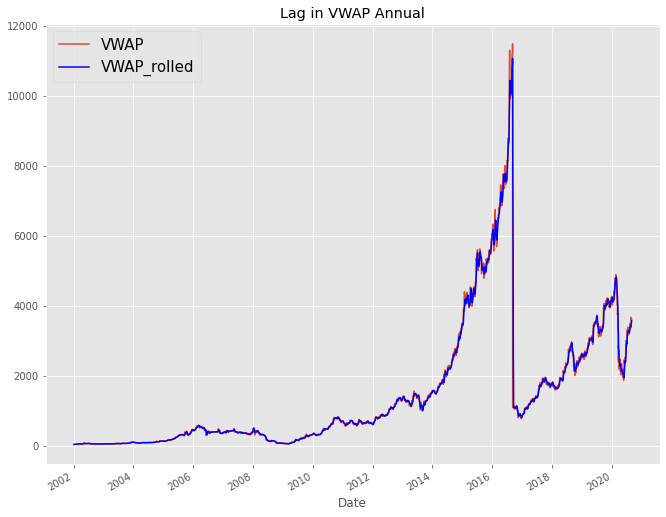

In [127]:
rolling_vwap = df['VWAP'].rolling(window=7)
df['VWAP_rolled'] = rolling_vwap.mean()
df['VWAP'].plot() 
df['VWAP_rolled'].plot(color='blue')
plt.title('Lag in VWAP Annual')
plt.legend(fontsize=15)
pyplot.show()

# Autocorrelation plot

Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
 "Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot..." - *Introduction to Time Series Forecasting With Python*, Jason Brownlee.

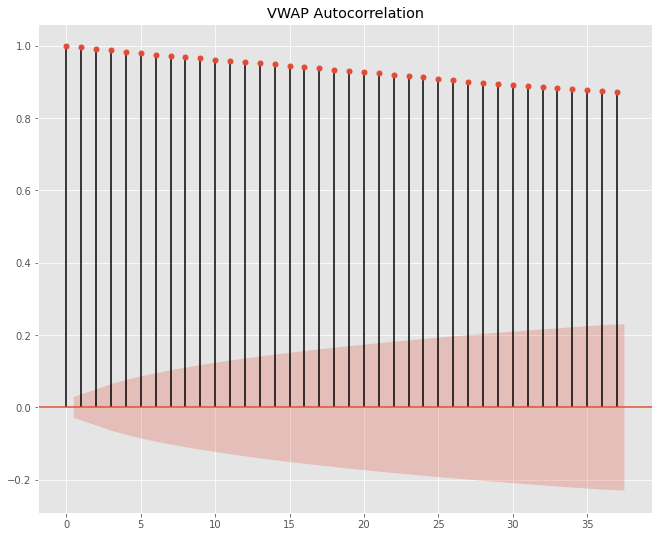

In [128]:
plot_acf(df['VWAP'],title="VWAP Autocorrelation")
plt.show()

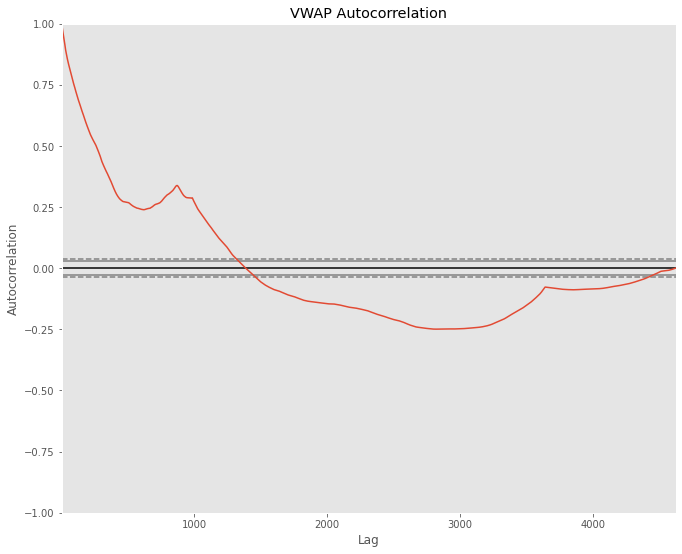

In [129]:
autocorrelation_plot(df['VWAP'])
plt.title('VWAP Autocorrelation')
pyplot.show()

## Partial Autocorrelation

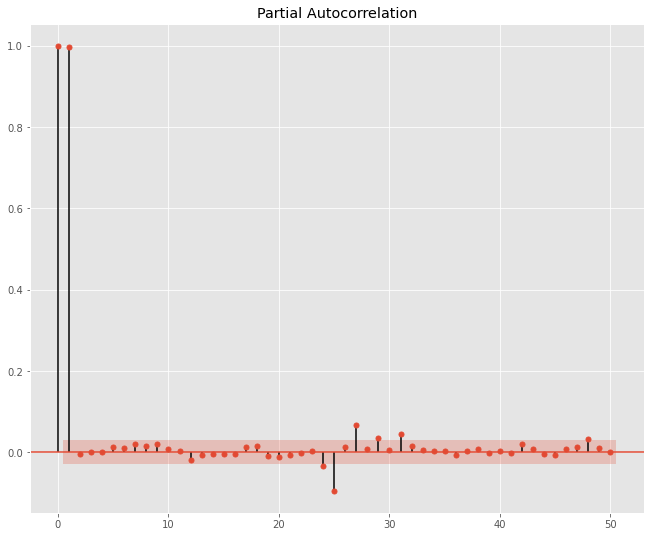

In [130]:
plot_pacf(df['VWAP'],lags=50)
plt.show()

# Stationarity-
We'll check with the Augmented Dickey-Fuller test for stationarity in the dataset. A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

In [131]:
def adf():    
    result = adfuller(df['VWAP'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1]) 
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [132]:
adf()

ADF Statistic: -2.571828
p-value: 0.098961
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [133]:
df['VWAP'] = df['VWAP'].diff()
df.dropna(inplace=True)

In [134]:
adf()

ADF Statistic: -13.427082
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Running the example prints the test statistic value of -2.57. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). Hence the values are relatively not random, but depend on the prior recorded values.



# Decompose Time Series Data
> "Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting."- *Introduction to Time Series Forecasting With Python*, Jason Brownlee.




In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 

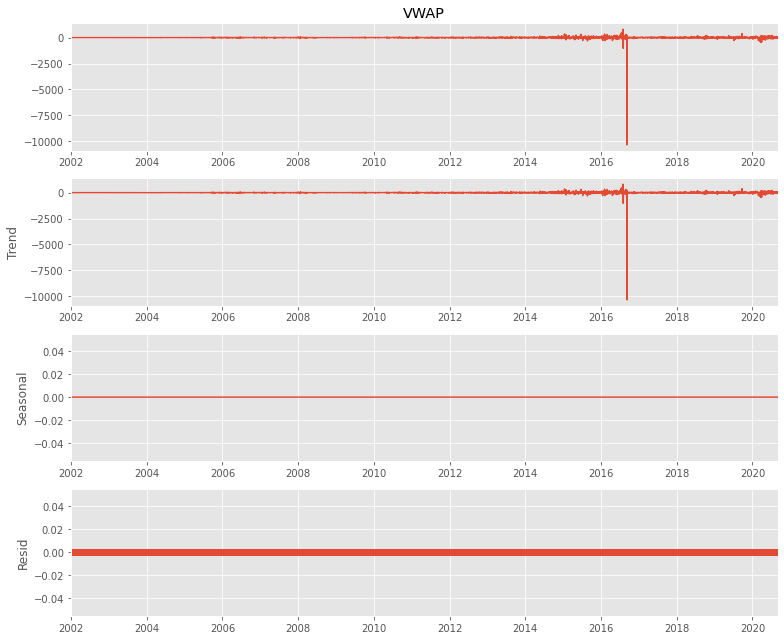

In [ ]:
series = df['VWAP']
result = seasonal_decompose(series, model='additive', period=1) 
rcParams['figure.figsize'] = 11, 9
result.plot()
pyplot.show()

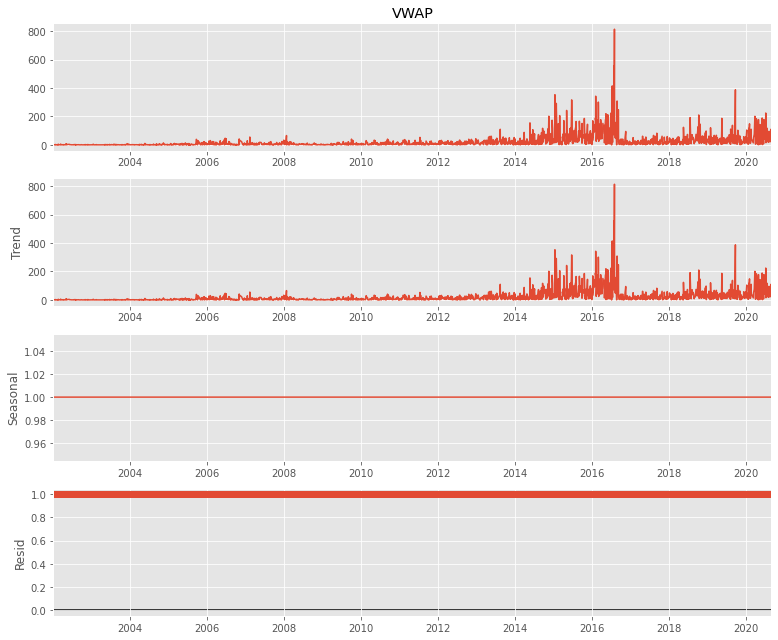

In [ ]:
series = df[df['VWAP'] > 0]['VWAP']
result = seasonal_decompose(series, model='multiplicative', period=1) 
rcParams['figure.figsize'] = 11, 9
result.plot()
pyplot.show()

# Feature Engineering:
Appling sliding window statistic on columns to obtain lag values, to be used in modelling the dataset. The mean and standard lag values of the features will be useful to forcast out of sample or test sample of VWAP. 

In [135]:
df2 = df.copy()
df2.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,vwap_boxcox,VWAP_rolled
Date,,,,,,,,,,,,,,,,
2002-01-10,BAJAUTOFIN,EQ,34.75,35.40,35.50,34.25,34.25,34.40,0.05,1050,3.672500e+09,18235.5,450.0,0.4286,4.077227,34.330000
2002-01-11,BAJAUTOFIN,EQ,34.40,34.35,34.75,34.35,34.35,34.35,-0.62,675,2.319625e+09,18235.5,675.0,1.0000,4.053857,34.404286
2002-01-14,BAJAUTOFIN,EQ,34.35,35.10,36.35,34.20,34.20,34.20,0.82,2888,1.016096e+10,18235.5,2588.0,0.8961,4.084685,34.577143
2002-01-15,BAJAUTOFIN,EQ,34.20,35.50,36.75,35.50,36.00,36.00,1.15,950,3.451000e+09,18235.5,950.0,1.0000,4.126817,34.870000
2002-01-16,BAJAUTOFIN,EQ,36.00,38.75,38.90,36.00,38.90,38.65,1.13,19969,7.479410e+10,18235.5,16870.0,0.8448,4.167032,35.330000


In [136]:
df2.reset_index(drop=False,inplace=True)

In [137]:
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

In [138]:
df_rolled_3d = df2[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df2[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df2[lag_features].rolling(window=window3, min_periods=0)

In [139]:
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

In [140]:
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

In [141]:
for feature in lag_features:
    df2[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df2[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df2[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df2[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df2[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df2[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

In [142]:
df2.fillna(df.mean(), inplace=True)

In [143]:
df2.set_index("Date", drop=False, inplace=True)
df2.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,vwap_boxcox,VWAP_rolled,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-10,2002-01-10,BAJAUTOFIN,EQ,34.75,35.40,35.50,34.25,34.25,34.40,0.05,1050,3.672500e+09,18235.5,450.0,0.4286,4.077227,34.330000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-11,2002-01-11,BAJAUTOFIN,EQ,34.40,34.35,34.75,34.35,34.35,34.35,-0.62,675,2.319625e+09,18235.5,675.0,1.0000,4.053857,34.404286,35.500000,35.500000,35.500000,NaN,NaN,NaN,34.250000,34.250000,34.250000,NaN,NaN,NaN,1050.000000,1050.000000,1050.000000,NaN,NaN,NaN,3.672500e+09,3.672500e+09,3.672500e+09,NaN,NaN,NaN,18235.5,18235.5,18235.5,NaN,NaN,NaN
2002-01-14,2002-01-14,BAJAUTOFIN,EQ,34.35,35.10,36.35,34.20,34.20,34.20,0.82,2888,1.016096e+10,18235.5,2588.0,0.8961,4.084685,34.577143,35.125000,35.125000,35.125000,0.530330,0.530330,0.530330,34.299999,34.299999,34.299999,0.070711,0.070711,0.070711,862.500000,862.500000,862.500000,265.165039,265.165039,265.165039,2.996062e+09,2.996062e+09,2.996062e+09,9.566271e+08,9.566271e+08,9.566271e+08,18235.5,18235.5,18235.5,0.0,0.0,0.0
2002-01-15,2002-01-15,BAJAUTOFIN,EQ,34.20,35.50,36.75,35.50,36.00,36.00,1.15,950,3.451000e+09,18235.5,950.0,1.0000,4.126817,34.870000,35.533333,35.533333,35.533333,0.800521,0.800521,0.800521,34.266666,34.266666,34.266666,0.076376,0.076376,0.076376,1537.666626,1537.666626,1537.666626,1184.359009,1184.359009,1184.359009,5.384361e+09,5.384361e+09,5.384361e+09,4.191597e+09,4.191597e+09,4.191597e+09,18235.5,18235.5,18235.5,0.0,0.0,0.0
2002-01-16,2002-01-16,BAJAUTOFIN,EQ,36.00,38.75,38.90,36.00,38.90,38.65,1.13,19969,7.479410e+10,18235.5,16870.0,0.8448,4.167032,35.330000,35.950001,35.837502,35.837502,1.058300,0.892912,0.892912,34.683334,34.575001,34.575001,0.711220,0.619812,0.619812,1504.333374,1390.750000,1390.750000,1206.153564,1010.680725,1010.680725,5.310529e+09,4.901021e+09,4.901021e+09,4.238516e+09,3.556327e+09,3.556327e+09,18235.5,18235.5,18235.5,0.0,0.0,0.0


Months and Days are useful features to input in the model for predictions.

In [144]:
df2.Date = pd.to_datetime(df2.Date, format="%Y-%m-%d")
df2["month"] = df2.Date.dt.month
df2["day"] = df2.Date.dt.day

# Preparing model 
Note: The additional features supplied to time series problems are called exogenous regressors.

In [145]:
#Dropping NULL or infinite values to avoid errors.
df2.dropna(axis =0,inplace=True)
df2 =df2[~df2.isin([np.nan, np.inf, -np.inf]).any(1)]
df2=df2.resample('MS').sum()

In [146]:
df_train = df2[df2.index < "2019"]
df_test = df2[df2.index >= "2019"]

In [147]:
exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "day"]

In [148]:
#Dataset with target variable and exogeneous features 
df3 = pd.DataFrame()
df3['VWAP'] = df2['VWAP']
for i in exogenous_features:
    df3[i] = df2[i]
print(pd.infer_freq(df3.index, warn=True))

MS


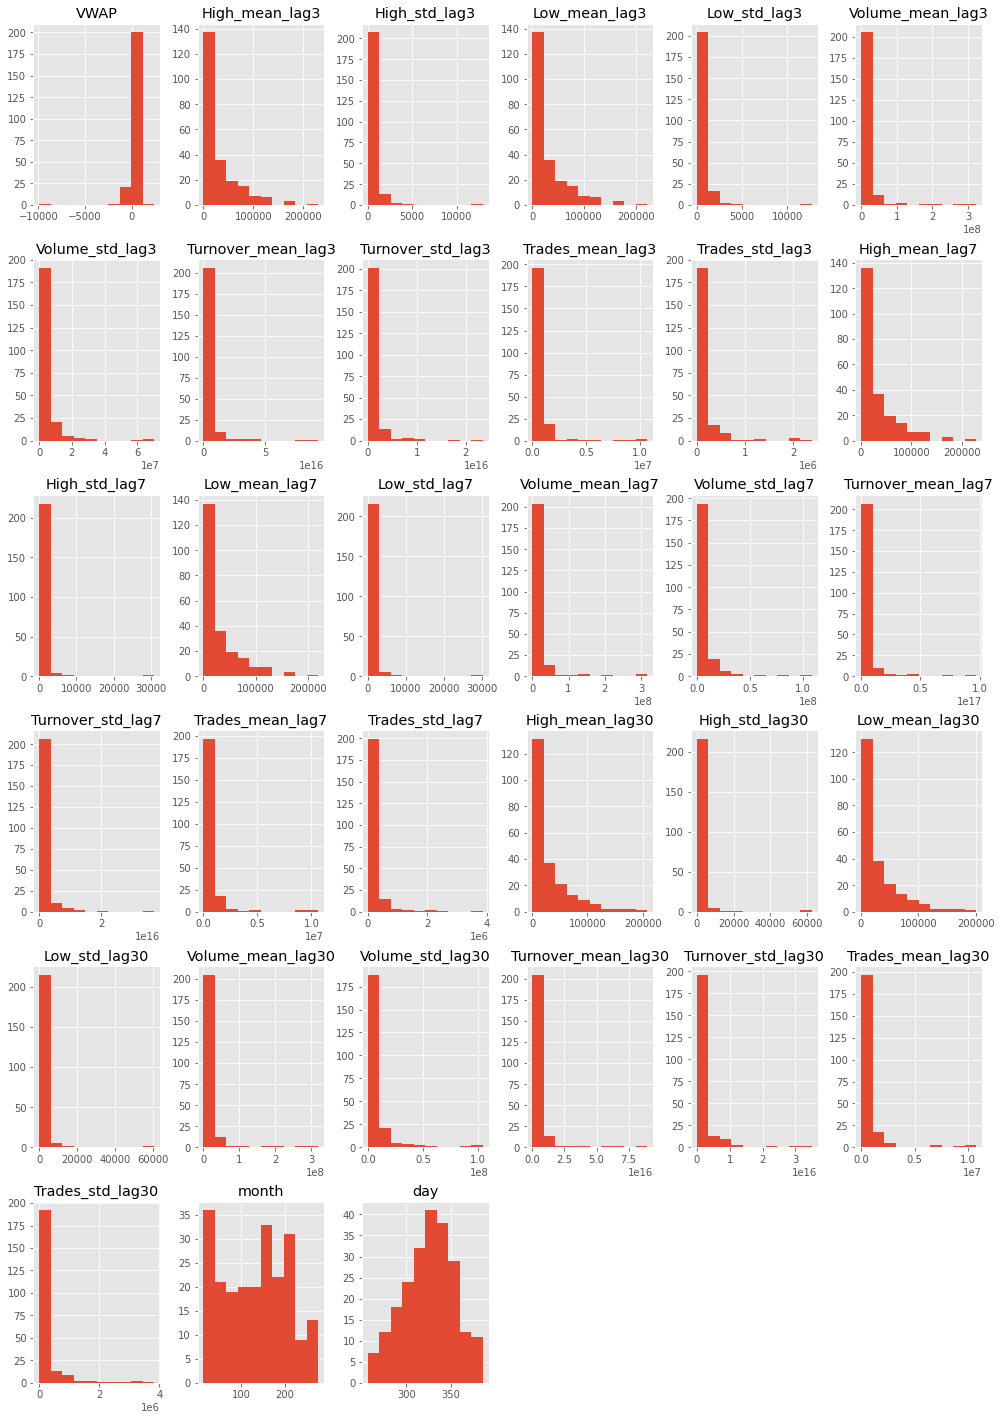

In [149]:
df4 = df3.copy()
fig = plt.figure(figsize = (17,25))
ax = fig.gca()
hist=df4.hist(ax = ax)

# ARIMA Models
An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average.

In [150]:
pip install pmdarima

In [151]:
from pmdarima.arima import auto_arima

In [152]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], m=12, seasonal=True, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2327.544, Time=4.12 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2311.896, Time=0.59 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2300.055, Time=3.60 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2293.224, Time=2.73 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3191.793, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2293.927, Time=0.94 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2296.074, Time=2.96 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2294.888, Time=7.33 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2291.829, Time=2.46 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2290.485, Time=6.71 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=2294.941, Time=6.45 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2310.554, Time=9.28 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=2302.544, Time=7.49 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=2287.765, Time=6.86 sec
 ARIMA(0,0,2)(1,0,0

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [153]:
forecast = model.predict(n_periods=len(df_test), exogenous=df_test[exogenous_features])
df_test["Forecast_ARIMAX"] = forecast

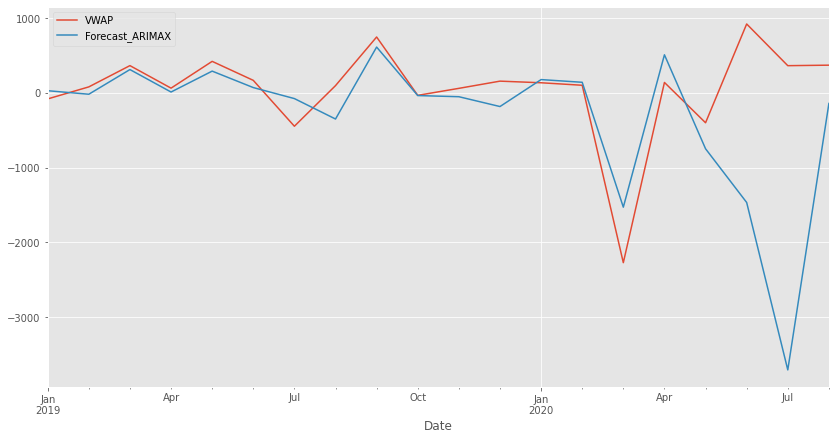

In [154]:
df_test[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_test.VWAP, df_test.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_test.VWAP, df_test.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 1093.1711820735638

MAE of Auto ARIMAX: 523.1631699815603


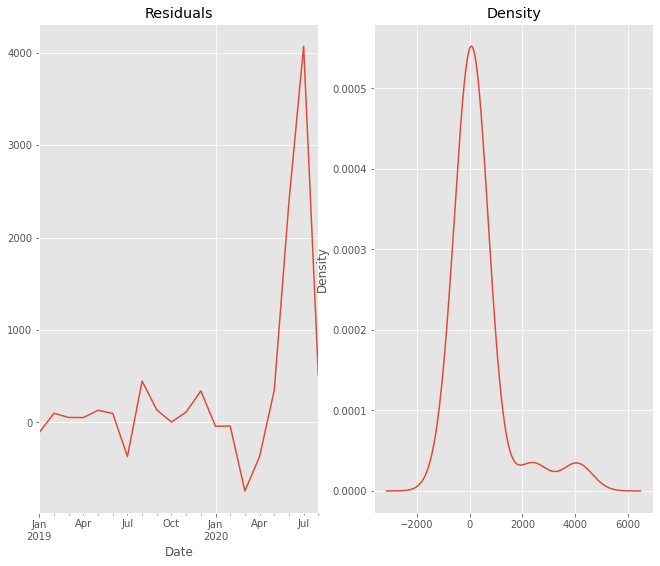

In [156]:
residuals = pd.Series(df_test['VWAP']-df_test['Forecast_ARIMAX'])
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()